In [3]:
import networkx as nx
import numpy as np
import math
import importlib

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci

# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics


In [4]:
G = nx.karate_club_graph()

In [5]:
print(nx.info(G))

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


In [6]:
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE")

INFO:Edge weight not detected in graph, use "weight" as default edge weight.


In [7]:
orc.compute_ricci_curvature()
G_orc = orc.G.copy()  # save an intermediate result

TRACE:Number of nodes: 34
TRACE:Number of edges: 78
TRACE:Start to compute all pair shortest path.
TRACE:0.000436 secs for all pair by NetworKit.
INFO:0.101945 secs for Ricci curvature computation.


Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,1) is 0.111111
Ollivier-Ricci curvature of edge (0,2) is -0.143750
Ollivier-Ricci curvature of edge (0,3) is 0.041667
Ollivier-Ricci curvature of edge (0,4) is -0.114583
Ollivier-Ricci curvature of edge (0,5) is -0.281250


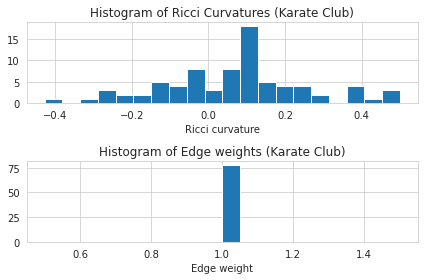

In [8]:
def show_results(G):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (Karate Club)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (Karate Club)")

    plt.tight_layout()

show_results(G_orc)

In [9]:
# Start a Ricci flow with Lin-Yau's probability distribution setting with 4 process.
orf = OllivierRicci(G, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")

# Do Ricci flow for 2 iterations
orf.compute_ricci_flow(iterations=2)

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:No ricciCurvature detected, compute original_RC...
INFO:0.204696 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 0 === 
INFO:0.195688 secs for Ricci curvature computation.
INFO: === Ricci flow iteration 1 === 
INFO:0.178086 secs for Ricci curvature computation.
INFO:0.633211 secs for Ricci flow computation.


In [10]:
orf.set_verbose("ERROR") # mute logs
orf.compute_ricci_flow(iterations=50)
G_rf = orf.G.copy()

Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,1) is -0.002814
Ollivier-Ricci curvature of edge (0,2) is -0.002783
Ollivier-Ricci curvature of edge (0,3) is -0.002808
Ollivier-Ricci curvature of edge (0,4) is -0.002823
Ollivier-Ricci curvature of edge (0,5) is -0.002830


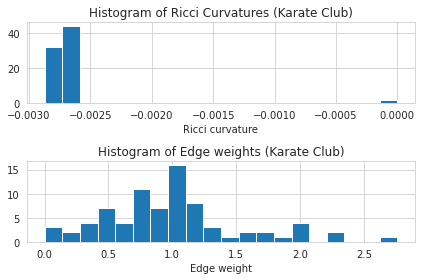

In [11]:
show_results(G_rf)

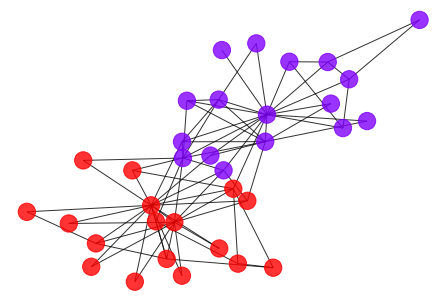

In [12]:
def draw_graph(G, clustering_label="club"):
    """
    A helper function to draw a nx graph with community.
    """
    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    node_color = le.fit_transform(list(complex_list.values()))

    nx.draw_spring(G,seed=0, nodelist=G.nodes(),
                   node_color=node_color,
                   cmap=plt.cm.rainbow,
                   alpha=0.8)

draw_graph(G_rf)

In [13]:
def ARI(G, clustering, clustering_label="club"):
    """
    Computer the Adjust Rand Index (clustering accuracy) of "clustering" with "clustering_label" as ground truth.

    Parameters
    ----------
    G : NetworkX graph
        A given NetworkX graph with node attribute "clustering_label" as ground truth.
    clustering : dict or list or list of set
        Predicted community clustering.
    clustering_label : str
        Node attribute name for ground truth.

    Returns
    -------
    ari : float
        Adjust Rand Index for predicted community.
    """

    complex_list = nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    y_true = le.fit_transform(list(complex_list.values()))

    if isinstance(clustering, dict):
        # python-louvain partition format
        y_pred = np.array([clustering[v] for v in complex_list.keys()])
    elif isinstance(clustering[0], set):
        # networkx partition format
        predict_dict = {c: idx for idx, comp in enumerate(clustering) for c in comp}
        y_pred = np.array([predict_dict[v] for v in complex_list.keys()])
    elif isinstance(clustering, list):
        # sklearn partition format
        y_pred = clustering
    else:
        return -1

    return metrics.adjusted_rand_score(y_true, y_pred)



def my_surgery(G_origin: nx.Graph(), weight="weight", cut=0):
    """A simple surgery function that remove the edges with weight above a threshold

    Parameters
    ----------
    G_origin : NetworkX graph
        A graph with ``weight`` as Ricci flow metric to cut.
    weight: str
        The edge weight used as Ricci flow metric. (Default value = "weight")
    cut: float
        Manually assigned cutoff point.

    Returns
    -------
    G : NetworkX graph
        A graph after surgery.
    """
    G = G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >= 0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default

    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    print("*************** Surgery time ****************")
    print("* Cut %d edges." % len(to_cut))
    G.remove_edges_from(to_cut)
    print("* Number of nodes now: %d" % G.number_of_nodes())
    print("* Number of edges now: %d" % G.number_of_edges())
    cc = list(nx.connected_components(G))
    print("* Modularity now: %f " % nx.algorithms.community.quality.modularity(G, cc))
    print("* ARI now: %f " % ARI(G, cc))
    print("*********************************************")

    return G

*************** Surgery time ****************
* Cut 12 edges.
* Number of nodes now: 34
* Number of edges now: 66
* Modularity now: 0.063117 
* ARI now: 0.072402 
*********************************************


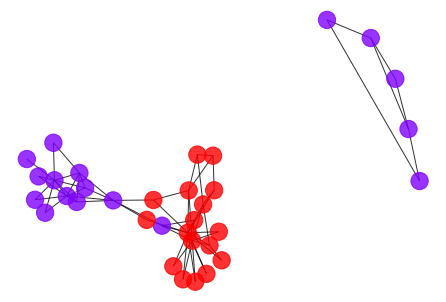

In [14]:
draw_graph(my_surgery(G_rf, cut=1.5))